## Load Data and Initial Grid Search

In [2]:
# Assign directory
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'
HANNAH = ''
ZIXUN = ''

ROOT_DIR = BRANDON
os.chdir(ROOT_DIR + 'testing-framework/')

DATA_NAME = 'toy-agriVision-red-wavelet'
GROUP = 'layer'
SKIP_OPTIMIZE_STEP = True

os.mkdir(DATA_NAME)
os.mkdir(os.path.join(DATA_NAME, "CSVs"))
os.mkdir(os.path.join(DATA_NAME, "plots"))

In [3]:
from utilities import *
from plot_utilities import *
''' Comment out the below two lines if you do not have Matlab installed and opened'''
import matlab.engine 
eng = matlab.engine.connect_matlab()

np.random.seed(42)

In [4]:
''' Only need to run commented code once'''
data_df = pd.read_pickle(f'../transformed-data/{DATA_NAME}.pickle')
min_group, max_group = 2, max(data_df[GROUP])
group_data_map = dict()
for group in np.arange(min_group, max_group + 1):
    data = np.append(data_df[(data_df['orientation'] == 'H') & (data_df[GROUP] == group)]['data'].iloc[0],
                     data_df[(data_df['orientation'] == 'V') & (data_df[GROUP] == group)]['data'].iloc[0])
    group_data_map[group] = np.sort(data)
pd.to_pickle(group_data_map, f'{DATA_NAME}/group_data_map.pickle')

group_data_map = pd.read_pickle(f'{DATA_NAME}/group_data_map.pickle')
group_data_map

{2: array([-4828.17578125, -2163.26367188, -1546.80664063, ...,
         1991.27539062,  3550.29492188,  6479.9765625 ]),
 3: array([-3285.71484375, -3098.34375   , -2570.07421875, ...,
         2396.765625  ,  2795.17578125,  4100.5       ]),
 4: array([-2808.8046875, -2699.2890625, -2357.578125 , ...,  1489.5390625,
         1741.09375  ,  1762.21875  ]),
 5: array([-2610.5     , -1791.65625 , -1092.953125, ...,  2498.953125,
         2508.671875,  2561.953125]),
 6: array([-2346.625  , -2025.40625, -2001.40625, ...,  2102.09375,
         2247.90625,  2321.25   ]),
 7: array([-1054.6875,  -988.625 ,  -819.625 , ...,   790.625 ,   857.9375,
         1126.8125]),
 8: array([-522.375, -464.875, -416.   , ...,  524.875,  542.875,  555.   ]),
 9: array([-205.75, -192.5 , -191.25, ...,  196.25,  197.5 ,  208.  ]),
 10: array([-84.5, -84. , -82.5, ...,  81. ,  87.5,  88.5])}

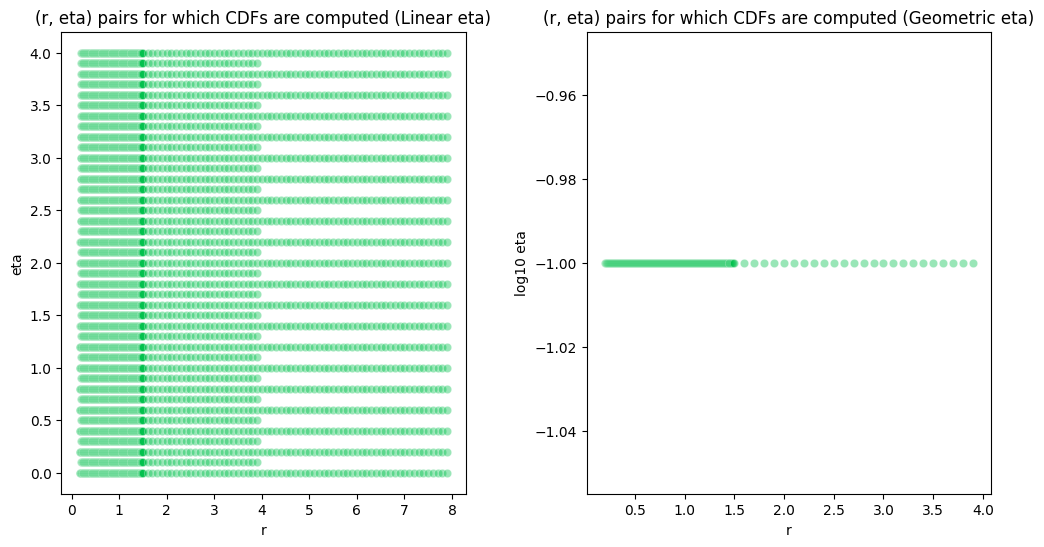

,"(r,eta),cdf",r,eta,cdf
0,"((0.17, 0), <scipy.interpolate._cubic.CubicSpl...",0.17,0.0,<scipy.interpolate._cubic.CubicSpline object a...
1,"((0.17, 0.2), <scipy.interpolate._cubic.CubicS...",0.17,0.2,<scipy.interpolate._cubic.CubicSpline object a...
2,"((0.17, 0.4), <scipy.interpolate._cubic.CubicS...",0.17,0.4,<scipy.interpolate._cubic.CubicSpline object a...
3,"((0.17, 0.6), <scipy.interpolate._cubic.CubicS...",0.17,0.6,<scipy.interpolate._cubic.CubicSpline object a...
4,"((0.17, 0.8), <scipy.interpolate._cubic.CubicS...",0.17,0.8,<scipy.interpolate._cubic.CubicSpline object a...
...,...,...,...,...
7226,"((7.9, 3.2), <scipy.interpolate._cubic.CubicSp...",7.90,3.2,<scipy.interpolate._cubic.CubicSpline object a...
7227,"((7.9, 3.4), <scipy.interpolate._cubic.CubicSp...",7.90,3.4,<scipy.interpolate._cubic.CubicSpline object a...
7228,"((7.9, 3.6), <scipy.interpolate._cubic.CubicSp...",7.90,3.6,<scipy.interpolate._cubic.CubicSpline object a...
7229,"((7.9, 3.8), <scipy.interpolate._cubic.CubicSp...",7.90,3.8,<scipy.interpolate._cubic.CubicSpline object a...


In [5]:
# Large grid search CDFs already computed (r = 0 to 8, eta = 0 to 3.9)

all_cdfs = combine_pickles('scipy_10000') | combine_pickles('mtlb_10000') | combine_pickles('mtlb_100000')
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

create_scatter_plots_log_eta(all_cdfs_df)

all_cdfs_df.sort_values(['r', 'eta'])

In [7]:
''' Only need to run commented code once'''

# master_df = pd.DataFrame(columns = [GROUP, 'num_samples', 'initial_param', 'kstest_stat_initial', 'best_param_eta_0', 'kstest_stat_eta0'])
# idx_eta0 = [i for i, param in enumerate(sorted(all_cdfs)) if np.isclose(param[1], 0, atol = 1e-40)]
# sorted_params = sorted(all_cdfs)
# for i, group in enumerate(np.arange(min_group, max_group+1)):
#     print("Processing group (layer/band) ", group)
#     sample = group_data_map[group]
#     ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs)
#     ksstats_eta0 = [ksstats[i] for i in idx_eta0]
#     idx_min_ksstats_eta0 = idx_eta0[np.argmin(ksstats_eta0)]
#     master_df.loc[i, :] = [group, sample.size, initial_param, min_stat, sorted_params[idx_min_ksstats_eta0], ksstats[idx_min_ksstats_eta0]]
# master_df = master_df.set_index(GROUP)
# master_df.to_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv')

min_group, max_group = 2, 8
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv', index_col=GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

Processing group (layer/band)  2
Processing group (layer/band)  3
Processing group (layer/band)  4
Processing group (layer/band)  5
Processing group (layer/band)  6
Processing group (layer/band)  7
Processing group (layer/band)  8


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0
layer,,,,,
2,2016,"(0.23, 0.0)",0.054355,"(0.23, 0)",0.054355
3,8064,"(0.28, 0.1)",0.076160,"(0.27, 0)",0.076389
4,32256,"(0.34, 0.0)",0.084234,"(0.34, 0)",0.084234
5,129024,"(0.44, 0.0)",0.101229,"(0.44, 0)",0.101229
6,516096,"(0.56, 0.2)",0.130902,"(0.8, 0)",0.130902
7,2064384,"(1.32, 0.1)",0.171286,"(1.25, 0)",0.171286
8,8257536,"(0.45, 0.3)",0.239567,"(1.25, 0)",0.239567


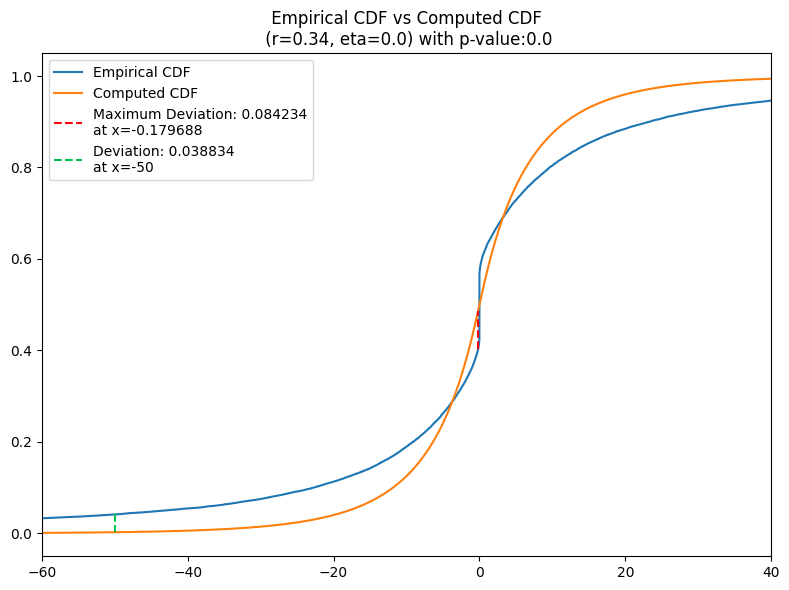

In [8]:
group = 4
visualize_cdf(group_data_map[group], 
              all_cdfs = all_cdfs, 
              params= master_df.loc[group, 'initial_param'], 
              n_samples=10000, interval = (-60, 40), 
              provided_loc = -50);

In [9]:
# Given that pvalue = 0.05 and I have n samples, what should the kstest statistic be?
# Note how as num_samples increases by a factor of 4, the cutoff decreases by a factor of 2
# Could potentially include the plot in `images/loglog_pvalue_numsamples.png` 

for group in np.arange(min_group, max_group+1):
    num_points = group_data_map[group].size
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = stats.kstwo(n=num_points).isf(0.05)    
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05
layer,,,,,,
2,2016,"(0.23, 0.0)",0.054355,"(0.23, 0)",0.054355,0.030163
3,8064,"(0.28, 0.1)",0.076160,"(0.27, 0)",0.076389,0.015103
4,32256,"(0.34, 0.0)",0.084234,"(0.34, 0)",0.084234,0.007557
5,129024,"(0.44, 0.0)",0.101229,"(0.44, 0)",0.101229,0.003780
6,516096,"(0.56, 0.2)",0.130902,"(0.8, 0)",0.130902,0.001890
7,2064384,"(1.32, 0.1)",0.171286,"(1.25, 0)",0.171286,0.000945
8,8257536,"(0.45, 0.3)",0.239567,"(1.25, 0)",0.239567,0.000473


In [10]:
r_d, eta_d = 3, 2 # Controls precision to which parameters are optimized
SKIP_OPTIMIZE_STEP = True

if SKIP_OPTIMIZE_STEP:
    r_d, eta_d = 2, 1
    master_df['kstest_stat_cd'] = master_df['kstest_stat_initial']
    master_df[f'best_r_d{r_d}'] = master_df['initial_param'].apply(lambda x : x[0])
    master_df[f'best_eta_d{eta_d}'] = master_df['initial_param'].apply(lambda x : x[1])

else:
    for group in np.arange(min_group, max_group+1): 
        sample = group_data_map[group]
        initial_param = master_df.loc[group, 'initial_param']
        master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'] = coord_descent_gengamma(sample, initial_param, 
                                                                                                                    r_depth = r_d, eta_depth=eta_d, 
                                                                                                                    scipy_int=False, group=group, 
                                                                                                                    eng=eng, DATA_NAME=DATA_NAME)
        master_df.loc[group, 'kstest_stat_cd'] = compute_ksstat(sample, combine_pickles(f'{DATA_NAME}_group{group}_10000')[(master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'])])
        print(f"{GROUP} {group} best parameters: {master_df.loc[group, 'kstest_stat_cd']}")


master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_cd'], row.loc['num_samples']), axis = 1)    
master_df[['num_samples', 'initial_param', 'kstest_stat_initial', f'best_r_d{r_d}', f'best_eta_d{eta_d}', 'kstest_stat_cd', 'n_pval_0.05']].to_csv(f'{DATA_NAME}/CSVs/optimized_params.csv')
master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05
layer,,,,,,,,,,
2,2016,"(0.23, 0.0)",0.054355,"(0.23, 0)",0.054355,0.030163,0.054355,0.23,0.0,637
3,8064,"(0.28, 0.1)",0.076160,"(0.27, 0)",0.076389,0.015103,0.076160,0.28,0.1,318
4,32256,"(0.34, 0.0)",0.084234,"(0.34, 0)",0.084234,0.007557,0.084234,0.34,0.0,252
5,129024,"(0.44, 0.0)",0.101229,"(0.44, 0)",0.101229,0.003780,0.101229,0.44,0.0,175
6,516096,"(0.56, 0.2)",0.130902,"(0.8, 0)",0.130902,0.001890,0.130902,0.56,0.2,105
7,2064384,"(1.32, 0.1)",0.171286,"(1.25, 0)",0.171286,0.000945,0.171286,1.32,0.1,63
8,8257536,"(0.45, 0.3)",0.239567,"(1.25, 0)",0.239567,0.000473,0.239567,0.45,0.3,31


## Comparing Empirical and Computed CDF/PDF

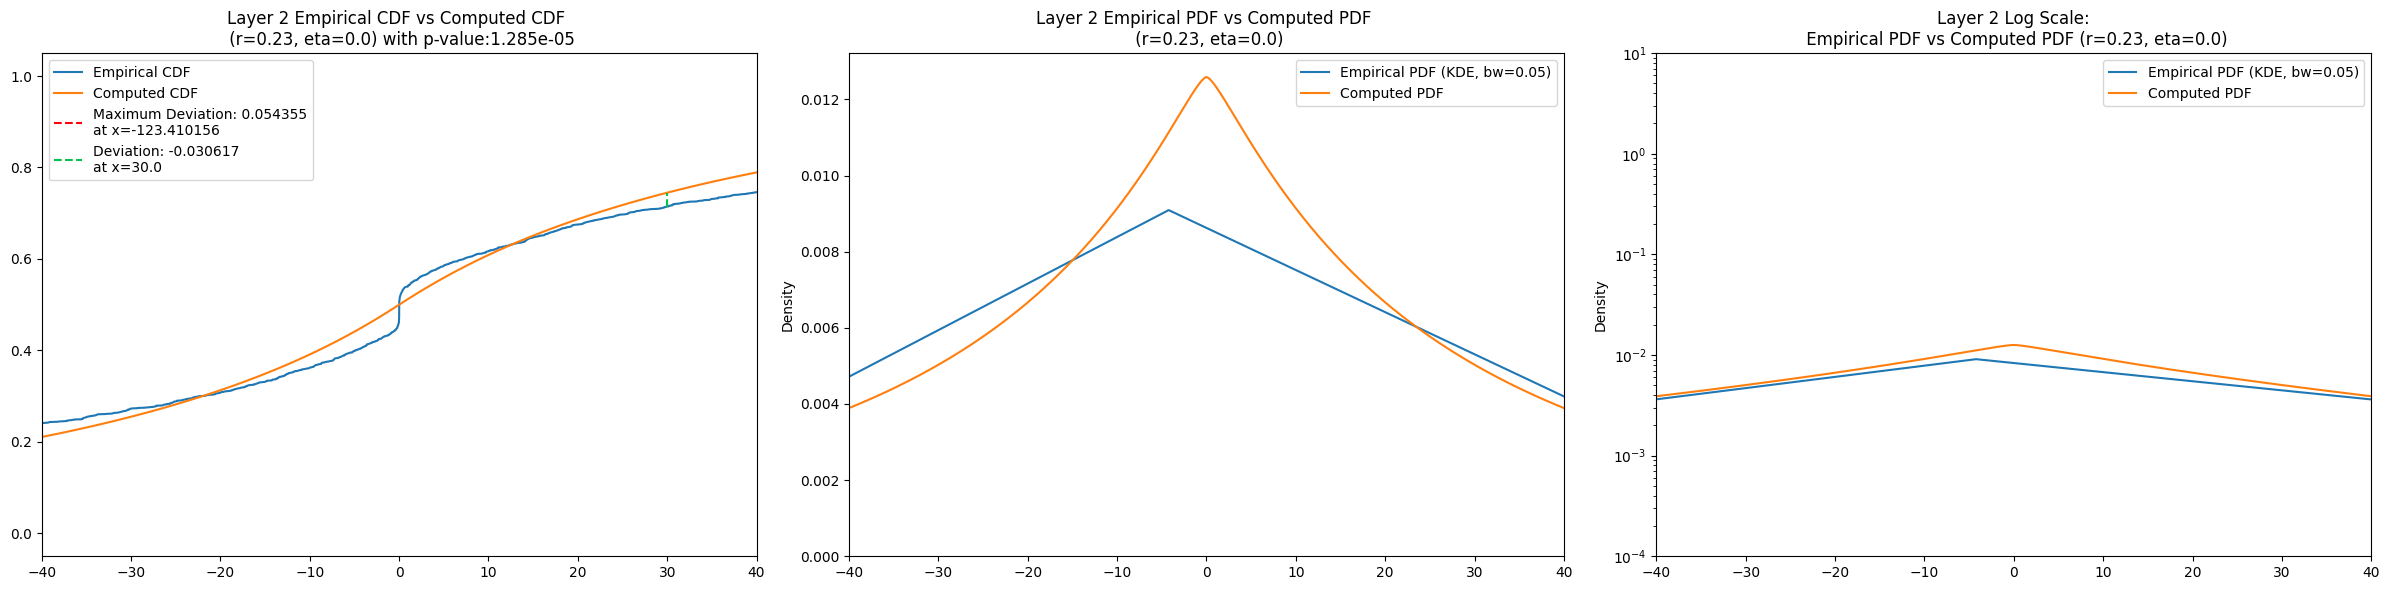

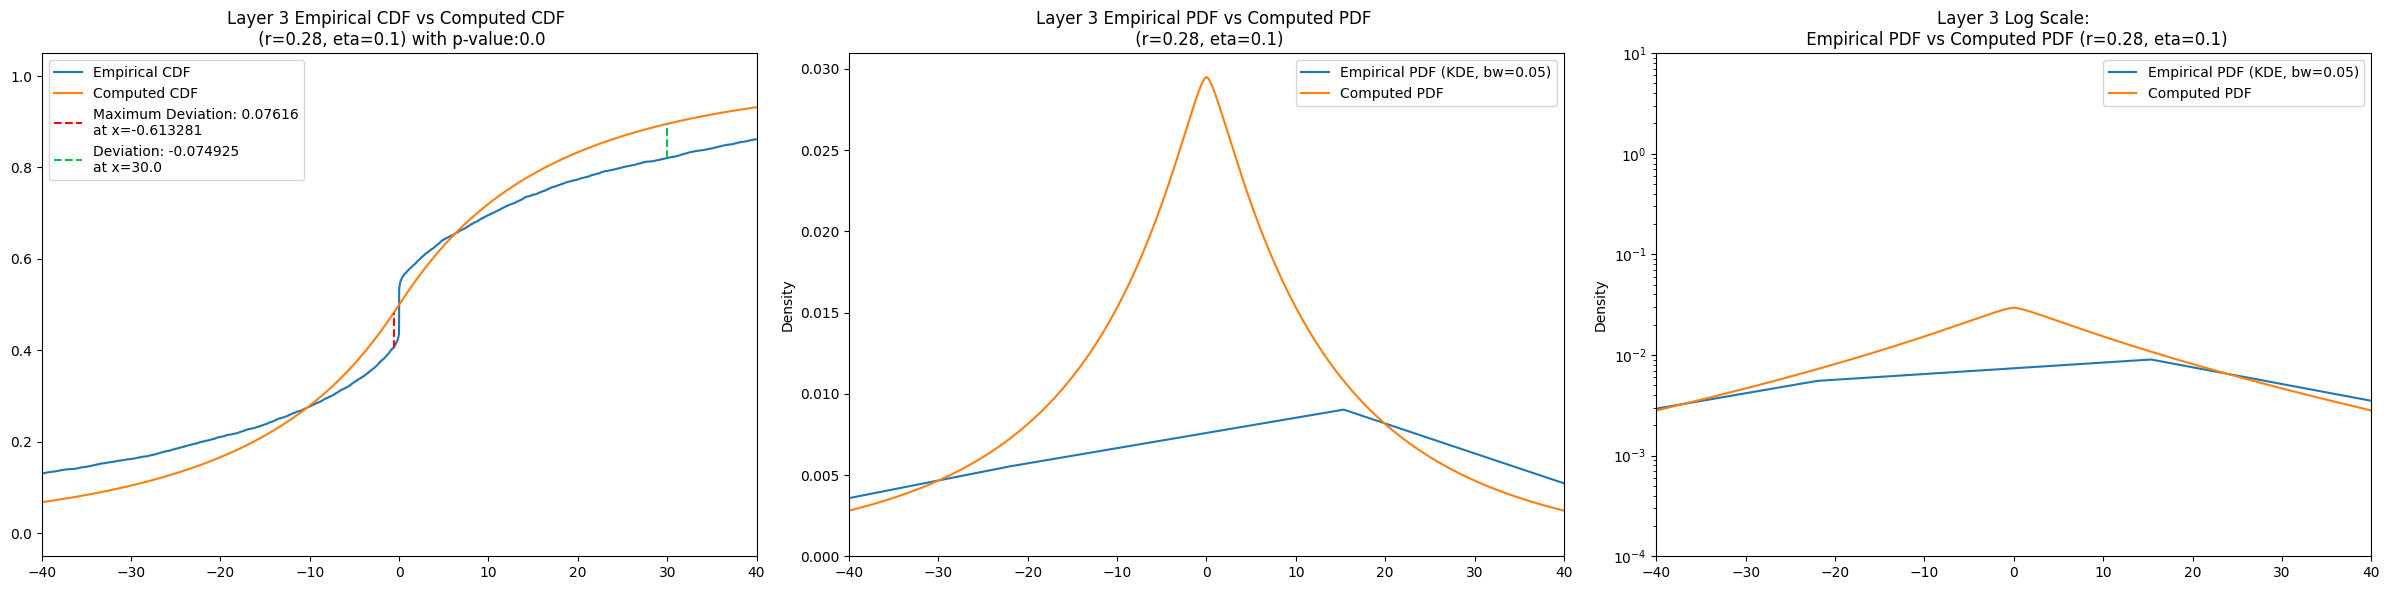

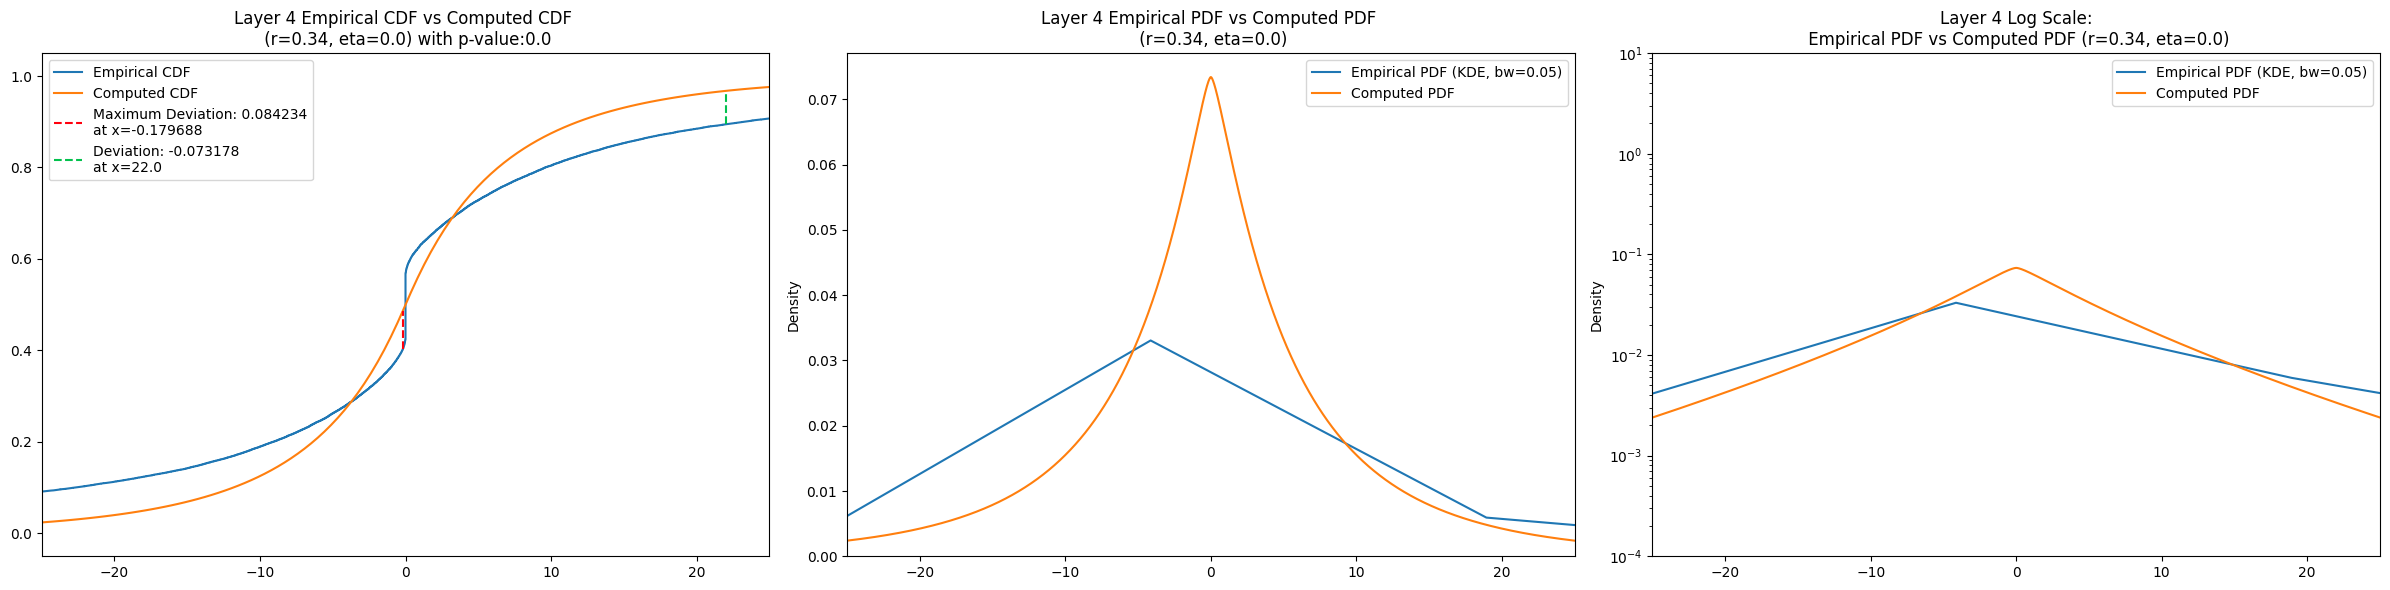

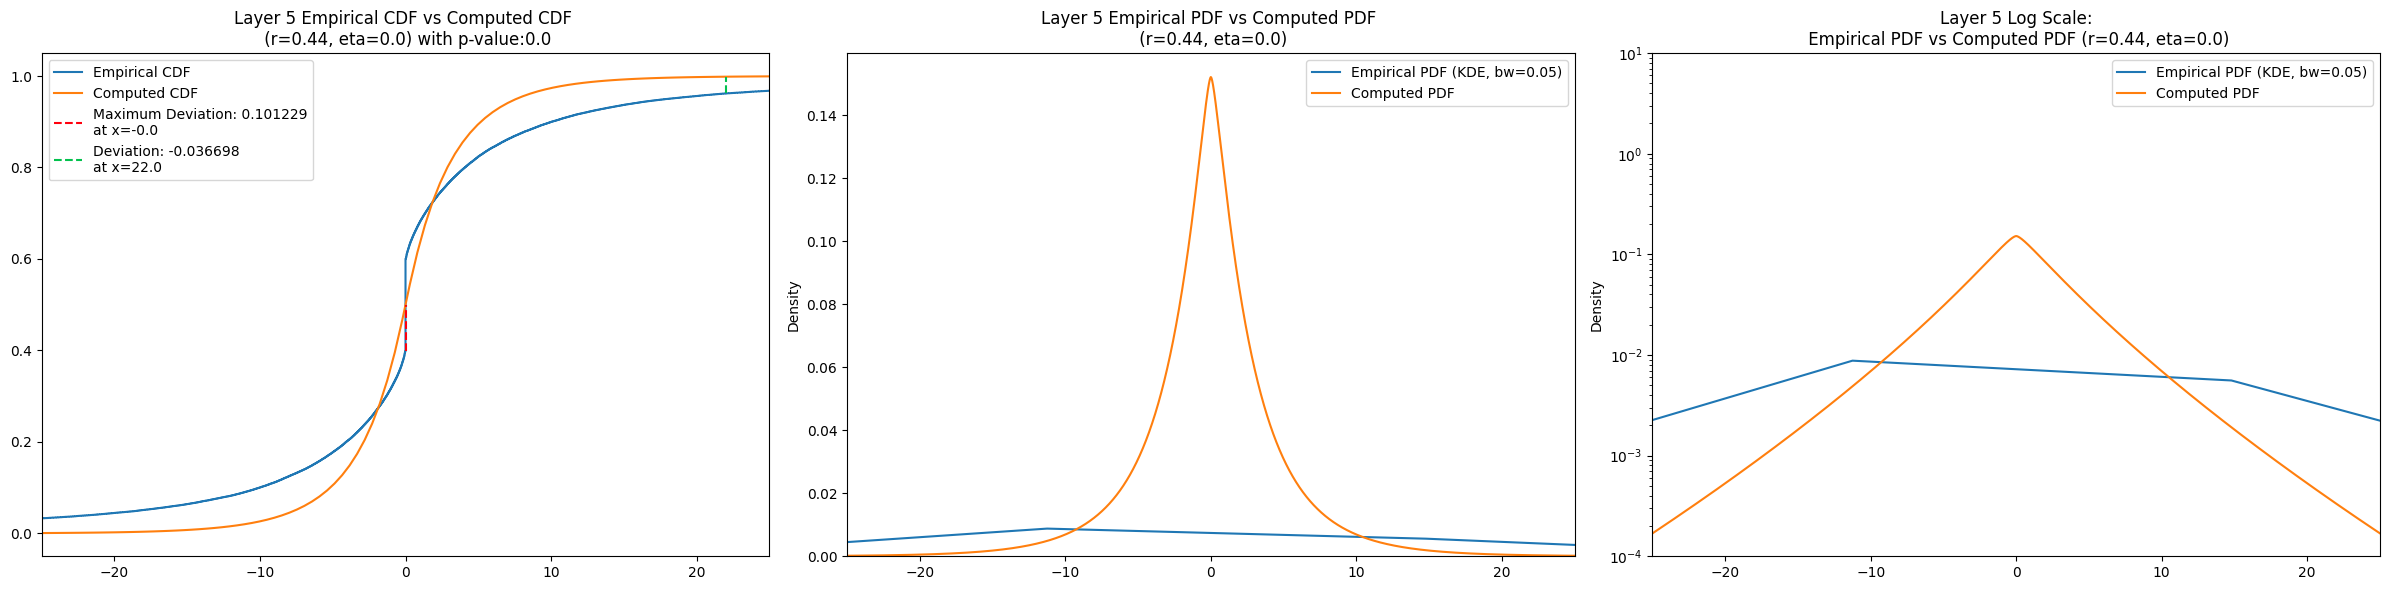

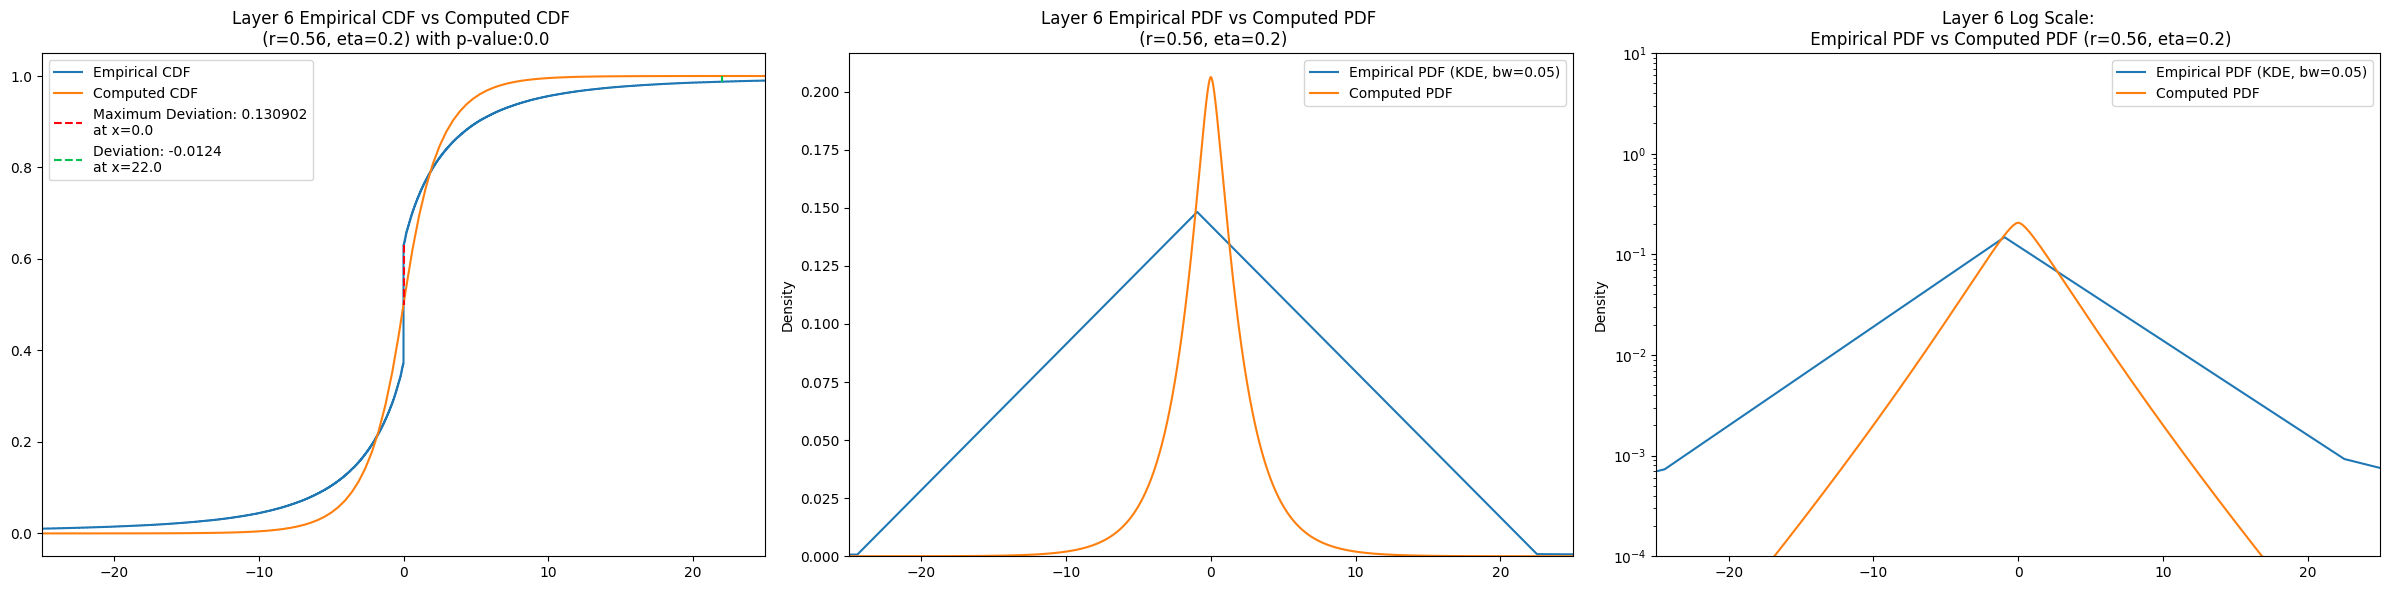

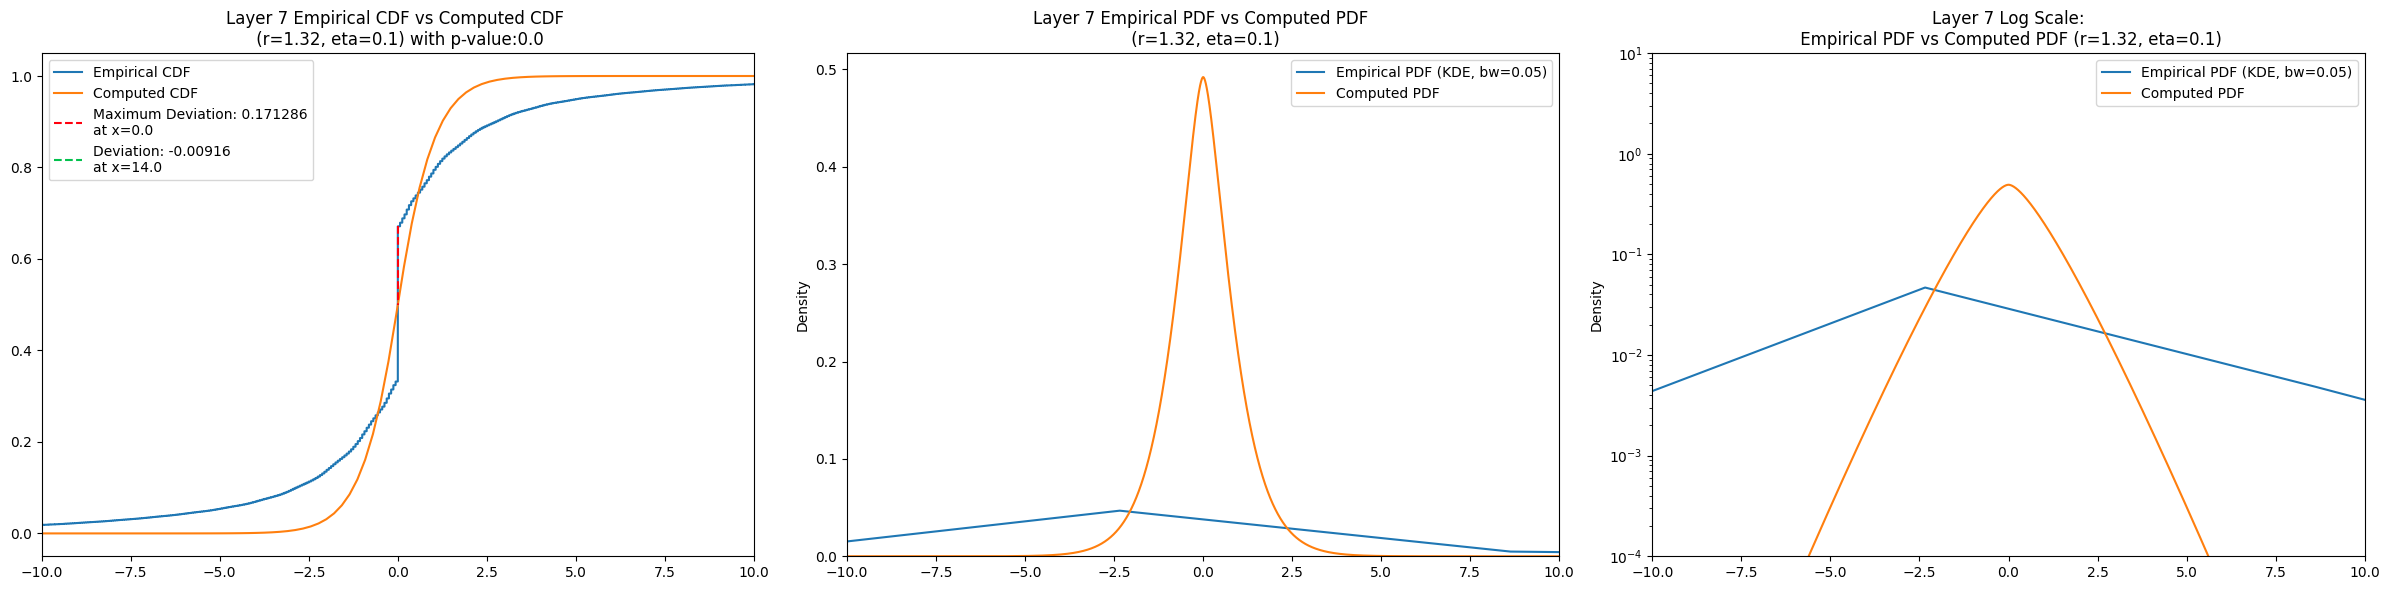

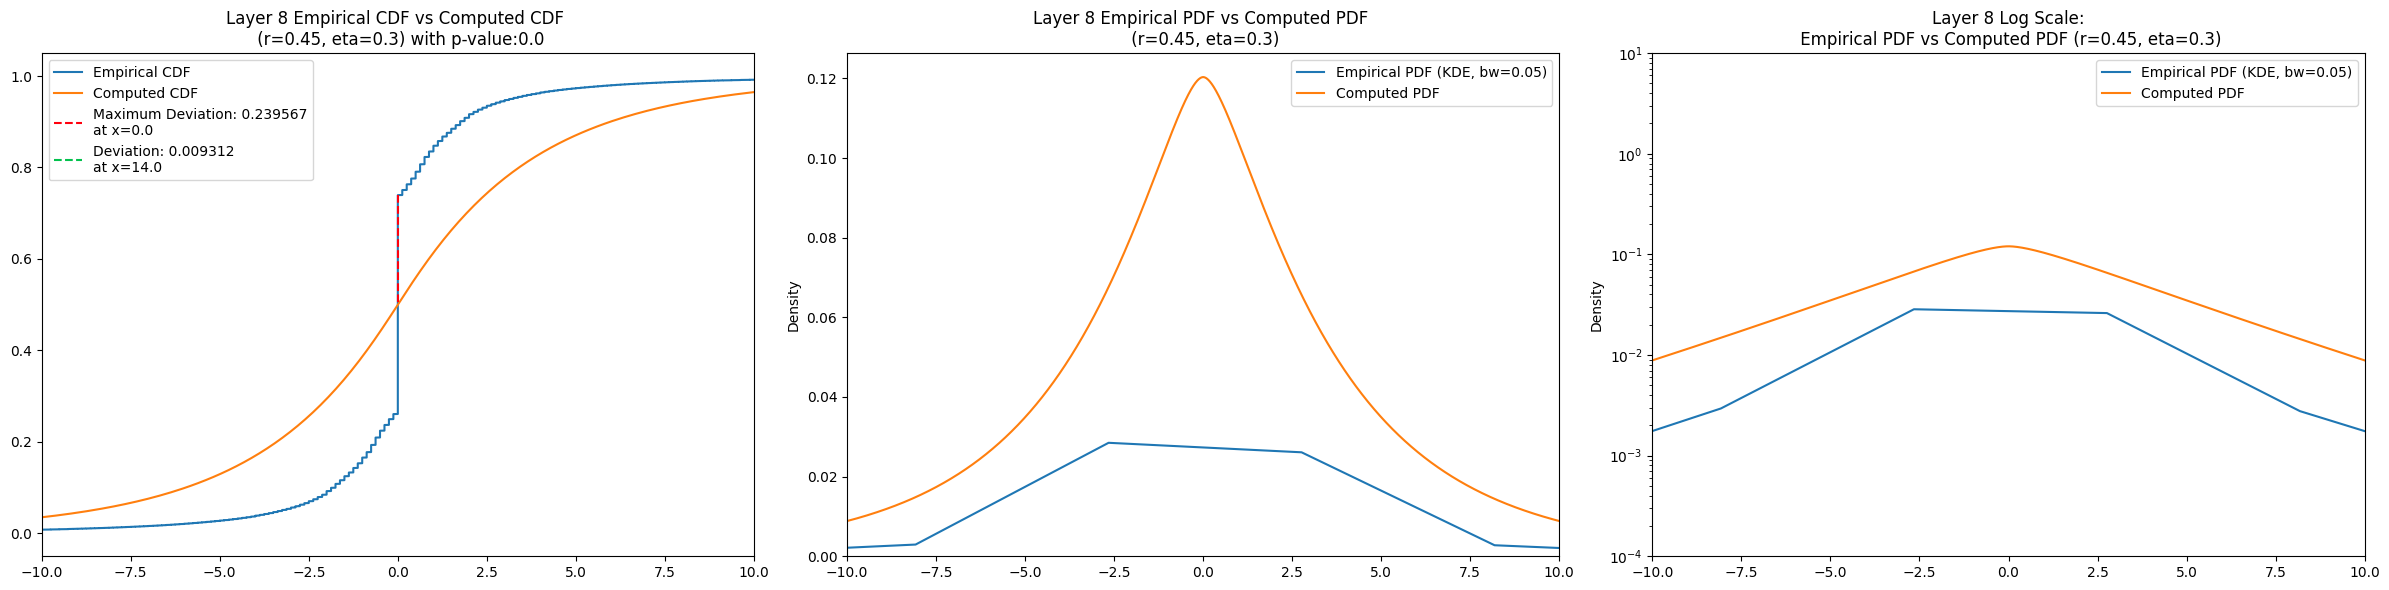

In [11]:
for group in np.arange(min_group, max_group+1):
    group_info = master_df.loc[group]
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (group_info[f'best_r_d{r_d}'], group_info[f'best_eta_d{eta_d}']), 
                    log_scale = True,
                    all_cdfs = all_cdfs,
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(f'{DATA_NAME}/plots/compare_cdf_pdf_layer_{group}.png', bbox_inches = 'tight')

## Comparing with Gaussian and Laplace

In [12]:
SKIP_OPTIMIZE_STEP = True

def coord_descent_scipy(sample, initial_param):
    '''
    '''
    r_0, eta_0 = initial_param
    find_r_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_0), method = 'bounded', bounds = (max(0.5, r_0-0.1), r_0+0.1))
    r_1 = find_r_1['x']
    find_eta_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_eta', r_1), method = 'bounded', bounds = (max(0, eta_0-0.1), eta_0+0.1))
    eta_1 = find_eta_1['x']
    find_r_2 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_1), method = 'bounded', bounds = (max(0.5, r_1-0.1), r_1+0.1))

    r_2 = find_r_2['x']

    return r_2, eta_1, find_r_2['fun']

if SKIP_OPTIMIZE_STEP:
    master_df[f'best_r_scipy'], master_df[f'best_eta_scipy'], master_df[f'kstest_stat_cd_scipy'] =   master_df[f'best_r_d{r_d}'],  master_df[f'best_eta_d{eta_d}'], master_df['kstest_stat_initial']
else:
    for group in np.arange(min_group, max_group+1):
        master_df.loc[group, f'best_r_scipy'], master_df.loc[group, f'best_eta_scipy'], master_df.loc[group, f'kstest_stat_cd_scipy'] = coord_descent_scipy(group_data_map[group], master_df.loc[group, 'initial_param'])

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,best_r_scipy,best_eta_scipy,kstest_stat_cd_scipy
layer,,,,,,,,,,,,,
2,2016,"(0.23, 0.0)",0.054355,"(0.23, 0)",0.054355,0.030163,0.054355,0.23,0.0,637,0.23,0.0,0.054355
3,8064,"(0.28, 0.1)",0.076160,"(0.27, 0)",0.076389,0.015103,0.076160,0.28,0.1,318,0.28,0.1,0.076160
4,32256,"(0.34, 0.0)",0.084234,"(0.34, 0)",0.084234,0.007557,0.084234,0.34,0.0,252,0.34,0.0,0.084234
5,129024,"(0.44, 0.0)",0.101229,"(0.44, 0)",0.101229,0.003780,0.101229,0.44,0.0,175,0.44,0.0,0.101229
6,516096,"(0.56, 0.2)",0.130902,"(0.8, 0)",0.130902,0.001890,0.130902,0.56,0.2,105,0.56,0.2,0.130902
7,2064384,"(1.32, 0.1)",0.171286,"(1.25, 0)",0.171286,0.000945,0.171286,1.32,0.1,63,1.32,0.1,0.171286
8,8257536,"(0.45, 0.3)",0.239567,"(1.25, 0)",0.239567,0.000473,0.239567,0.45,0.3,31,0.45,0.3,0.239567


In [13]:
for group in np.arange(min_group, max_group+1):
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(min(master_df.loc[group, 'kstest_stat_cd'], master_df.loc[group, 'kstest_stat_cd_scipy'])), 6)

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,2016,"(0.23, 0.0)",0.054355,"(0.23, 0)",0.054355,0.030163,0.054355,0.23,0.0,637,...,50.000000,0.111250,3.457830e-22,50.000000,0.070727,3.253540e-09,43.009300,0.062005,3.513600e-07,1.285260e-05
3,8064,"(0.28, 0.1)",0.076160,"(0.27, 0)",0.076389,0.015103,0.076160,0.28,0.1,318,...,24.260300,0.092907,5.016290e-61,19.123900,0.078342,1.706030e-43,15.872000,0.080846,2.700650e-46,3.986550e-41
4,32256,"(0.34, 0.0)",0.084234,"(0.34, 0)",0.084234,0.007557,0.084234,0.34,0.0,252,...,9.669630,0.096210,2.535360e-260,7.222120,0.085155,6.107080e-204,5.820930,0.086979,9.142470e-213,1.480850e-199
5,129024,"(0.44, 0.0)",0.101229,"(0.44, 0)",0.101229,0.003780,0.101229,0.44,0.0,175,...,3.891560,0.105535,0.000000e+00,2.765770,0.101229,0.000000e+00,2.224600,0.101229,0.000000e+00,0.000000e+00
6,516096,"(0.56, 0.2)",0.130902,"(0.8, 0)",0.130902,0.001890,0.130902,0.56,0.2,105,...,1.589470,0.130902,0.000000e+00,1.082400,0.130902,0.000000e+00,0.867103,0.130902,0.000000e+00,0.000000e+00
7,2064384,"(1.32, 0.1)",0.171286,"(1.25, 0)",0.171286,0.000945,0.171286,1.32,0.1,63,...,0.601779,0.171286,0.000000e+00,0.415189,0.171286,0.000000e+00,1.725250,0.171286,0.000000e+00,0.000000e+00
8,8257536,"(0.45, 0.3)",0.239567,"(1.25, 0)",0.239567,0.000473,0.239567,0.45,0.3,31,...,0.107678,0.239567,0.000000e+00,2.765050,0.239567,0.000000e+00,0.036088,0.239567,0.000000e+00,0.000000e+00


# Examining Tail Behavior

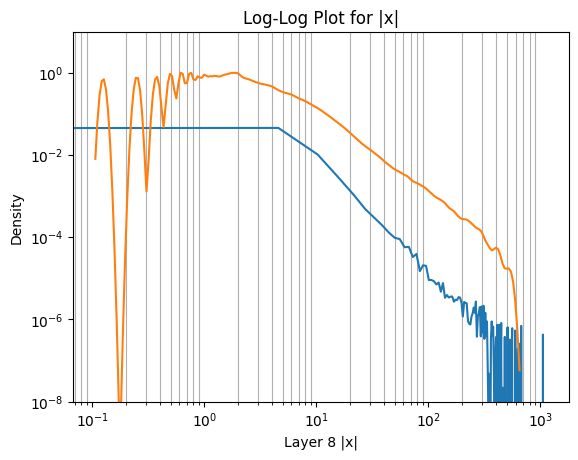

In [14]:
bw = 0.05
group = 7
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_7.png', bbox_inches = 'tight')

bw = 0.05
group = 8
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_8.png', bbox_inches = 'tight')


In [15]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[master_df.loc[layer, 'initial_param']]
            elif distro == 'gaussian':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for group in np.arange(min_group, max_group+1):
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/testing-framework/utilities.py:296: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
/Users/brandonmarks/opt/anaconda3/envs/Research/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/testing-framework/utilities.py:296: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
/Users/brandonmarks/opt/anaconda3/envs/Research/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/testing-framework/utilities.py:296: RuntimeWarning: divide by zero encountered i

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,...,kstest_ratio_gengamma_tail0,kstest_ratio_gengamma_tail10,kstest_ratio_gaussian_tail0,kstest_ratio_gaussian_tail10,kstest_ratio_laplace_tail0,kstest_ratio_laplace_tail10,kstest_ratio_t_tail0,kstest_ratio_t_tail10,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,,,,,,,,,,,,
2,2016,"(0.23, 0.0)",0.054355,"(0.23, 0)",0.054355,0.030163,0.054355,0.23,0.0,637,...,"(0.89337, 1712800000.0)","(0.92491, 1712800000.0)","(0.857, inf)","(0.85971, inf)","(0.857, inf)","(0.85971, inf)","(0.86004, 12.504)","(0.86354, 12.504)",0.054355,0.054355
3,8064,"(0.28, 0.1)",0.076160,"(0.27, 0)",0.076389,0.015103,0.076160,0.28,0.1,318,...,"(0.84226, 1710500000.0)","(0.91591, 1710500000.0)","(0.78804, inf)","(0.81641, inf)","(0.81765, inf)","(0.86993, inf)","(0.82406, 31.268)","(0.91077, 31.268)",0.075769,0.075769
4,32256,"(0.34, 0.0)",0.084234,"(0.34, 0)",0.084234,0.007557,0.084234,0.34,0.0,252,...,"(0.82581, 206540000.0)","(0.9154, 206540000.0)","(0.78893, inf)","(0.90154, inf)","(0.81312, inf)","(0.8666, inf)","(0.81857, 30.514)","(0.90546, 30.514)",0.077703,0.077703
5,129024,"(0.44, 0.0)",0.101229,"(0.44, 0)",0.101229,0.003780,0.101229,0.44,0.0,175,...,"(0.79325, 2722000000.0)","(0.92376, 2722000000.0)","(0.77554, inf)","(0.90398, inf)","(0.79211, inf)","(0.89952, inf)","(0.79435, 32.695)","(0.9206, 32.695)",0.080523,0.074239
6,516096,"(0.56, 0.2)",0.130902,"(0.8, 0)",0.130902,0.001890,0.130902,0.56,0.2,105,...,"(0.74069, 2015300000.0)","(0.96023, 2015300000.0)","(0.74069, inf)","(0.95588, inf)","(0.74069, inf)","(0.95588, inf)","(0.74069, 61.937)","(0.95945, 61.937)",0.059018,0.039849
7,2064384,"(1.32, 0.1)",0.171286,"(1.25, 0)",0.171286,0.000945,0.171286,1.32,0.1,63,...,"(0.66387, 15665000000.0)","(0.98196, 15665000000.0)","(0.66387, inf)","(0.98196, inf)","(0.66387, inf)","(0.98196, inf)","(0.36206, 2.1358)","(0.36206, 2.1358)",0.106673,0.018507
8,8257536,"(0.45, 0.3)",0.239567,"(1.25, 0)",0.239567,0.000473,0.239567,0.45,0.3,31,...,"(0.20543, 8122200.0)","(0.2271, 8122200.0)","(0.52168, inf)","(0.99181, inf)","(0.35867, inf)","(0.99196, inf)","(0.52168, 1264.6)","(0.99182, 1260.3)",0.210654,0.027258


# Results

## KS-Test Statistics

In [16]:
#master_df.filter(regex='num_samples|kstest_stat.*')
#master_df.filter(regex='num_samples|param.*')
# master_df.filter(regex='.*gaussian')
master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,kstest_stat_initial,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd_scipy,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,
2,0.054355,0.054355,0.030163,0.054355,0.111250,0.070727,0.062005,0.054355,0.054355
3,0.076160,0.076389,0.015103,0.076160,0.092907,0.078342,0.080846,0.075769,0.075769
4,0.084234,0.084234,0.007557,0.084234,0.096210,0.085155,0.086979,0.077703,0.077703
5,0.101229,0.101229,0.003780,0.101229,0.105535,0.101229,0.101229,0.080523,0.074239
6,0.130902,0.130902,0.001890,0.130902,0.130902,0.130902,0.130902,0.059018,0.039849
7,0.171286,0.171286,0.000945,0.171286,0.171286,0.171286,0.171286,0.106673,0.018507
8,0.239567,0.239567,0.000473,0.239567,0.239567,0.239567,0.239567,0.210654,0.027258
